## Final Project Submission

Please fill out:
* Student name: FREDRICK KYEKI
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Stella waithera
* Blog post URL:


## House Sales in King County, Washington, USA

## Overview
The project aims to provide provide actionable insights to a real estate firm by analyzing aspects of the houses datasets to guide their decision-making process. These insights can help them develop a strategic plan to invest in profitable homes and compete effectively in the real estate industry.

## 1. Business Understanding
A real estate firm needs a reliable model to predict house prices based on its features. With an accurate estimate, the firm can quickly identify underpriced houses to invest in and generate the maximum amount of profit upon resale.

## 2. Data Understanding
We used data sourced from King County Housing Dataset CSV. The data represents houses with information on price, bedrooms, bathrooms, sqft living, sqft lot, floors, view, aqnd year built. Total data used was from 21597 homes split 80/20 for training and testing. Variables include price, bedrooms, bathrooms, sqft living, sqft lot, floors, view, aqnd year built.

Properties of variables of interest:
1. Price: Continuous numeric (float). Represents the sale price of houses in the dataset.
2. Bedrooms: Discrete numeric (integer). Represents the number of bedrooms in each house.
3. Bathrooms: Continuous numeric (float).Represents the number of bathrooms in each house.
4. Sqft living: Continuous numeric (integer). Represents the total square footage of the living space in each house.
5. Floors: Discrete numeric (float). Represents the number of floors in each house.
6. View: Categorical (object). Represents the view rating of the property.
7. Year built: Discrete numeric (integer). Represents the year each house was built.

## 3. Data Preparation
The following describes the data cleaning process to remove any inconsistencies in the data and prepare it for analysis and modeling.

1. Importing Libraries: Importing the necessary Python libraries, including Pandas, NumPy, Matplotlib, and Seaborn, which are commonly used for data manipulation and visualization.
2. Data Loading: Reading the house data from a CSV file ("kc_house_data.csv") into a Pandas DataFrame using pd.read_csv().
3. Data Cleaning: Used house _data_df.head() to inspect the first few rows of the DataFrame. Checked the shape of the DataFrame using house_data_df.shape to determine the number of rows and columns. Used house_data_df.info() to get information about the data types and missing values in each column. Checked for duplicate rows using house_data_df.duplicated().
4. Data Exploration: Created various visualizations to explore the relationships between variables, such as scatter plots and box plots, to understand how features like square footage, the number of bathrooms, bedrooms, floors, and year built relate to house prices.
5. Investigate polynomial relationships and interactions between variables in greater details.

In [548]:
# Your code here - remember to use markdown cells for comments as well!
# Importing the relevant libraries
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [549]:
# Reading the house data into a DataFrame
house_data_df = pd.read_csv("data/kc_house_data.csv")

In [550]:
# Exploring the structure and content of the DataFrame
house_data_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [551]:
to_drop = [
'date',
'sqft_above',
'sqft_basement',
'yr_renovated',
'zipcode',
'lat',
'long',
'sqft_living15',
'sqft_lot15',
]

house_data_df.drop(columns=to_drop, inplace=True)

In [552]:
# Looking at the info printout
house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21597 non-null  int64  
 1   price        21597 non-null  float64
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   sqft_living  21597 non-null  int64  
 5   sqft_lot     21597 non-null  int64  
 6   floors       21597 non-null  float64
 7   waterfront   19221 non-null  object 
 8   view         21534 non-null  object 
 9   condition    21597 non-null  object 
 10  grade        21597 non-null  object 
 11  yr_built     21597 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.0+ MB


In [553]:
# Cheking whether there are missing values
house_data_df.isna().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
view             63
condition         0
grade             0
yr_built          0
dtype: int64

In [554]:
# Dropping null values in the 'view' column
house_data_df = house_data_df.dropna(subset=['view'])

In [555]:
# Dropping null values in the 'waterfront' column
house_data_df = house_data_df.dropna(subset=['waterfront'])

In [556]:
# Cheking for duplicates
house_data_df.duplicated()

1        False
2        False
3        False
4        False
5        False
         ...  
21591    False
21592    False
21593    False
21594    False
21596    False
Length: 19164, dtype: bool

In [557]:
# Summary statistics for the numerical columns in the DataFrame
summary_statistics = house_data_df.describe()
print(summary_statistics)

                 id         price      bedrooms     bathrooms   sqft_living  \
count  1.916400e+04  1.916400e+04  19164.000000  19164.000000  19164.000000   
mean   4.594087e+09  5.414490e+05      3.374452      2.117029   2082.038301   
std    2.876912e+09  3.709009e+05      0.928676      0.769241    921.918226   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.124077e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.905082e+09  4.500000e+05      3.000000      2.250000   1920.000000   
75%    7.334501e+09  6.439625e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors      yr_built  
count  1.916400e+04  19164.000000  19164.000000  
mean   1.506174e+04      1.495173   1971.039553  
std    4.077215e+04      0.540308     29.388020  
min    5.200000e+02      1.000000   1900.000000  
25%    5.040000e+03      1.000000   19

## Price Distribution with Outliers

In [558]:
# Calculating summary statistics for the 'price' column.
price_summary = house_data_df['price'].describe()
print(price_summary)

count    1.916400e+04
mean     5.414490e+05
std      3.709009e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.439625e+05
max      7.700000e+06
Name: price, dtype: float64


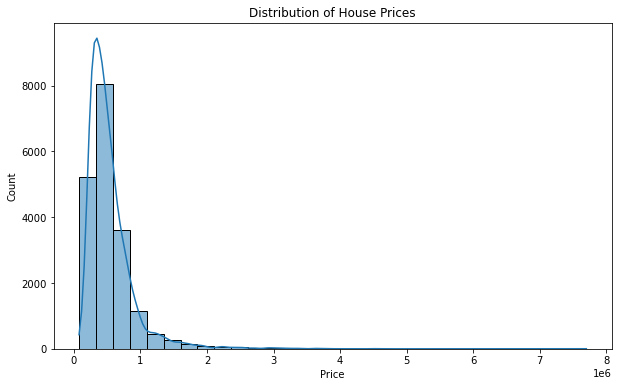

In [559]:
# Data Exploration
# Exploring the data by plotting some graphs to visualize the distribution of features.
# Using seaborn to create a histogram of the 'price' column.
plt.figure(figsize=(10, 6))
sns.histplot(house_data_df['price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

## Price Distribution without Outliers

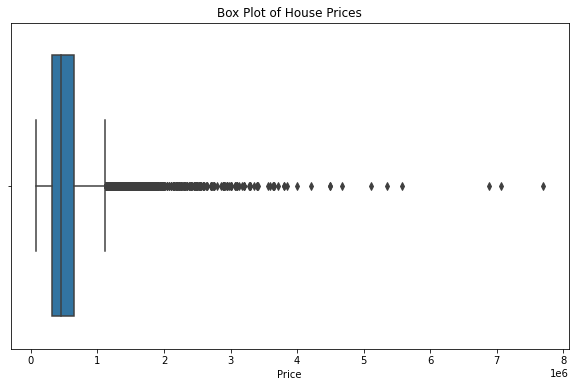

In [560]:
# Creating a box plot to identify outliers in the 'price' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=house_data_df['price'])
plt.title('Box Plot of House Prices')
plt.xlabel('Price')
plt.show()

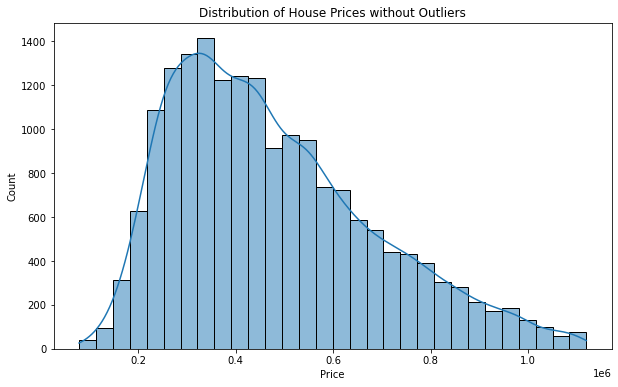

In [561]:
# Calculating the Interquartile Range (IQR) to identify outliers
Q1 = house_data_df['price'].quantile(0.25)
Q3 = house_data_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Defining the upper and lower bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to exclude outliers
hsedata_no_outliers = house_data_df[(house_data_df['price'] >= lower_bound) & (house_data_df['price'] <= upper_bound)]

# Creating a histogram of house prices without outliers
plt.figure(figsize=(10, 6))
sns.histplot(hsedata_no_outliers['price'], bins=30, kde=True)
plt.title('Distribution of House Prices without Outliers')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


## 2. Modelling
***
Since the response variable (the **Price**) contains outliers, the chosen procedure to provide the best regression model will be done with both datasets.\
 *i.e The one with outliers and the one without.*

### 2.1 Steps taken while modelling 
1. Start with the data with outliers and create the baseline model.
2. Add one predictor (independent) variable.
3. Check the performance.
4. Add a categorical variable.
5. Repeat steps 2 - 4 until adequate performance is reached.
6. Repeat these steps for the data without outliers and choose the best model.



### I. First Iteration (Base model)

In [562]:
# find the correlation matrix of the data
def highest_corr(df, resp_var, to_drop=[]):
    """finds highest corr
    Parameters:
    -----------
    df:
        DataFrame
    resp_var:
        Response variable
    to_drop:
        Columns to drop before finding the correlation matrix
    """
    df = df.drop(columns=to_drop)
    data_corr = df.corr()[resp_var]
    del data_corr[resp_var]

    max_corr = max(data_corr.values)
    print(data_corr, "\n")
    
    for k, v in data_corr.items():
        if v == max_corr:
            print('highest correlation: ', {k : v})

# highest correlation
highest_corr(house_data_df, 'price')

id            -0.018107
bedrooms       0.309057
bathrooms      0.526609
sqft_living    0.704428
sqft_lot       0.087430
floors         0.258797
yr_built       0.053433
Name: price, dtype: float64 

highest correlation:  {'sqft_living': 0.7044283177851761}


From the above result, **sqft_living** (which represents the square foot of living area) has the highest correlation with the price (0.7015872773843886), and is perfect for the baseline model, which is a simple linear regression.

> $$ \hat{y} = \hat{\beta_0} + \hat{\beta_1} x $$\
> Where: \
> $\hat{y}$ is `price`, the dependent (endogenous) variable, and \
> $x$ is `sqft_living`, the independent (exogenous) variable. 

When we fit our model, we are looking for $\hat{\beta_1}$ (the slope) and $\hat{\beta_0}$ (the intercept).

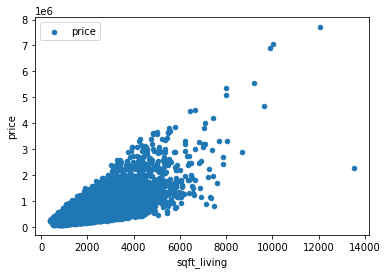

In [563]:
house_data_df.plot.scatter(x="sqft_living", y="price", label="price");

In [564]:
from statsmodels.api import OLS
import statsmodels.api as sm

# construct the exogenous and endogenous variables 
# i.e dependent (price) and independent variables (sqft_living)
y = house_data_df['price']
X_baseline = house_data_df[['sqft_living']]

In [565]:
# construct the baseline model
baseline_model = sm.OLS(endog=y, exog=sm.add_constant(X_baseline))
baseline_results = sm.OLS(endog=y, exog=sm.add_constant(X_baseline)).fit()
baseline_results_summary = baseline_results.summary()

In [566]:
# The summary of the model
print(baseline_results_summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.887e+04
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:16:42   Log-Likelihood:            -2.6638e+05
No. Observations:               19164   AIC:                         5.328e+05
Df Residuals:                   19162   BIC:                         5.328e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -4.86e+04   4697.110    -10.348      

### Interpretation:

### Simple Linear Regression Results

Looking at the summary above, we can see that the regression line we found was

$$ \hat{price} = -48,600 +  283.4016sqft\_living $$

* The model **is statistically significant** overall, with an F-statistic p-value well below 0.05
* The model explains about 49.6% of the variance in price.
    - indicating that approximately **49.6% of the variance in house prices is explained by the square footage of living space ("sqft_living").**
* The model coefficients (`const` and `sqft_living`) are both statistically significant, with t-statistic p-values well below 0.05
* If the sqft_living is $0ft^2$, we would expect price to be about $\$-48,600$
* For each increase of 1 square foot of living area, we see an associated increase in price of about $\$283.4016$


### Simple Linear Regression Visualization

We'll also plot the actual vs. predicted values:

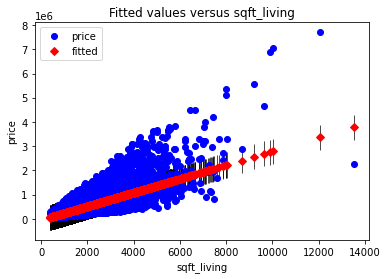

In [525]:
sm.graphics.plot_fit(baseline_results, "sqft_living")
plt.show()

The regression line:

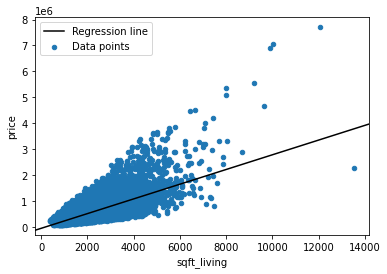

In [526]:
fig, ax = plt.subplots()
house_data_df.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax, color="black")
ax.legend();

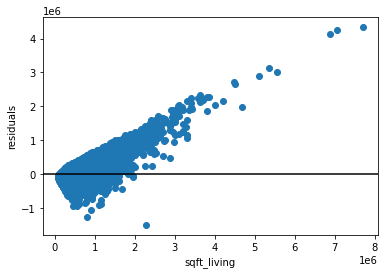

In [527]:
fig, ax = plt.subplots()

ax.scatter(house_data_df["price"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

## Adding Another Independent Variable

Now, we expand from our simple linear regression to a multiple linear regression, in bid to improve the overall model performance. Let's try find the next highly correlated variable to price after sqft_living to use in our next iteration.

### II. Second iteration

For the sake of efficient iteration, we create a python **class** to avoid unnecessary repetitions of code:

In [528]:
class RegressionAnalysis:
    """Regression class"""
    def __init__(self, df, y, X):
        """
        constructor function
        parameters:
        -----------
        df(pandas.DataFrame):
            DataFrame containing our data
        y (pandas.Series):
            endogenous (dependent) variable
        X (pandas.DataFrame):
            exogenous (independent) variable(s)
        """
        self.df = df
        self.X = X
        self.y = y
        
        self.model = sm.OLS(endog=y, exog=sm.add_constant(X))
        self.results = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    
    def summary(self):
        """returns model summary"""
        return self.results.summary()
    
    def plot_fit(self, var=None):
        """Plot fit against one regressor."""
        if not var:
            var = self.X.columns[0]
        sm.graphics.plot_fit(self.results, var)
        plt.show()
        
    def plot_partial_reg(self, figsize=(15,8)):
        """Plot partial regression for a set of regressors."""
        fig = plt.figure(figsize=figsize)
        sm.graphics.plot_partregress_grid(self.results, exog_idx=list(self.X.columns), fig=fig)
        plt.tight_layout()
        plt.show()
    
    def plot_ccpr(self):
        """Generate CCPR plots against a set of regressors, plot in a grid."""
        fig = plt.figure(figsize=(15,5))
        sm.graphics.plot_ccpr_grid(self.results, exog_idx=list(self.X.columns), grid=(1,2), fig=fig)
        plt.tight_layout()
        plt.show()

In [529]:
# next highly correlated variable
highest_corr(house_data_df, 'price', ['sqft_living'])

id          -0.018107
bedrooms     0.309057
bathrooms    0.526609
sqft_lot     0.087430
floors       0.258797
yr_built     0.053433
Name: price, dtype: float64 

highest correlation:  {'bathrooms': 0.5266090477103713}


It looks like the number of `bathrooms` is the next most strongly _positively_ correlated predictor, so let's add that.

In [530]:
indep_vars = ['sqft_living', 'bathrooms']
X_second = house_data_df[indep_vars]
X_second.head()

,sqft_living,bathrooms
1,2570,2.25
2,770,1.00
3,1960,3.00
4,1680,2.00
5,5420,4.50


In [531]:
# check bathroom values before analysis
house_data_df['bathrooms'].unique()

array([2.25, 1.  , 3.  , 2.  , 4.5 , 2.5 , 1.75, 2.75, 1.5 , 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 0.5 , 5.5 , 6.75,
       6.  , 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

Since the number of bathrooms should be discrete numerial value (i.e. we cannot have 2.75 bathrooms), we have to floor the values to a discrete value before any sort of analysis on the variable.

In [532]:
house_data_df['bathrooms'] = house_data_df['bathrooms'].apply(int)
house_data_df['bathrooms'].apply(int).unique()

array([2, 1, 3, 4, 0, 5, 6, 8, 7], dtype=int64)

In [533]:
# reselect the variables
indep_vars = ['sqft_living', 'bathrooms']
X_second = house_data_df[indep_vars]

second_iteration = RegressionAnalysis(house_data_df, y, X_second)

# let's see the summary
print(second_iteration.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     9464.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:08:55   Log-Likelihood:            -2.6636e+05
No. Observations:               19164   AIC:                         5.327e+05
Df Residuals:                   19161   BIC:                         5.328e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.989e+04   5157.920    -11.611      

### Interpretation:

### Second Iteration Regression Results

Looking at the summary above, we can see that the regression line we found was

$$ \hat{price} = -59,890 + 272.7382sqft\_living + 19,120bathrooms$$

* The model **is statistically significant** overall, with an **F-statistic p-value** well below 0.05
* The model exhibits an **R-squared value of 49.7%**:
    - indicating that approximately **49.7% of the variance in house prices is explained by the square footage of living space       ("sqft_living") and the number of bathrooms in the houses**
    - slight improvement of 0.1%.
* The model coefficients (`const`, `sqft_living` and `bathrooms`) are statistically significant, with t-statistic p-values well below 0.05
* For each increase of 1 square foot of living area, we see an associated increase in price of about $\$272.7382$
    - this here is an decrease of $-10.66$ from the last model, which means that number of bathrooms was not meaningfully confounding in the relationship between sqft_living and price.
* For each increase of 1 bathroom, we see an associated decrease in price of about $\$19,120$

* The model predicts a price of $\$-59,890$ when `sqft_living` and number of `bathrooms` are 0. 

### Second Iteration Regression Visualization

#### i) Model Fit

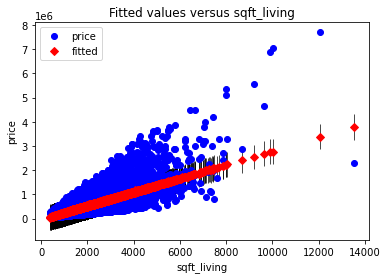

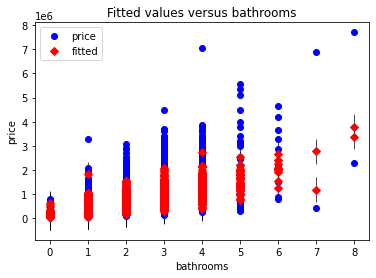

In [534]:
# plot model fit for sqft_living and bathrooms
second_iteration.plot_fit('sqft_living')
second_iteration.plot_fit('bathrooms')

From the above model fit plot of the bathrooms variables appears a bit different from the sqft_living due to it's discrete nature.

#### ii.) Partial Regression Plot

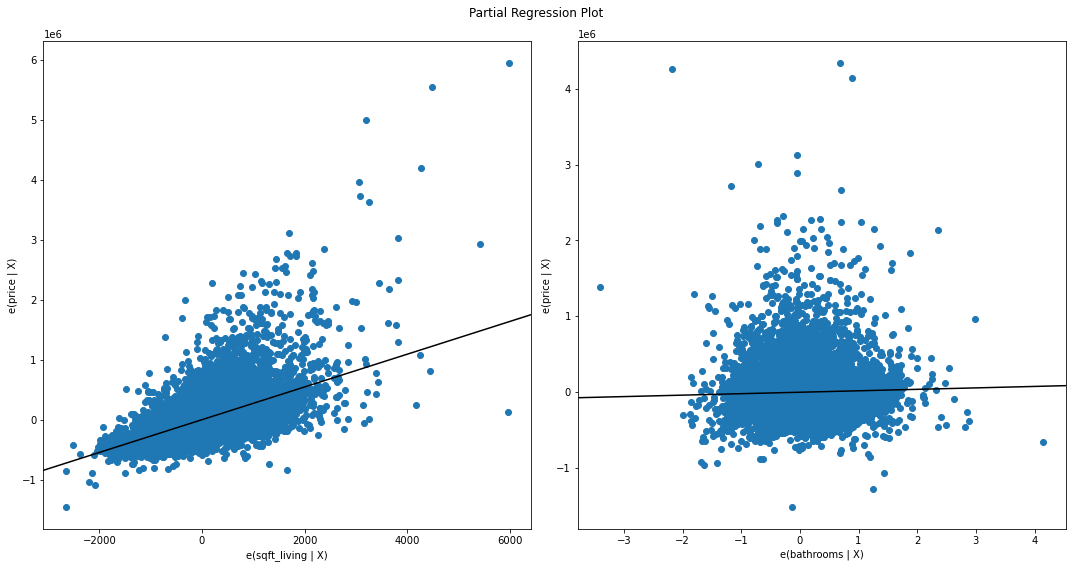

In [535]:
# plot partial regression plot
second_iteration.plot_partial_reg()

This plot explains the unique contribution of each of the independent variables.

- From left:
    - the `sqft_living`  regression plot shows a linear relationship with a non-zero slope, and that means that it is beneficial to add *sqft_living* to the model, vs. having a model without *sqft_living* (i.e. a model with just an intercept and *bathrooms*)
    - The partial regression plot for `bathrooms` is similarly showing the marginal contribution of `bathrooms` compared to a model with just *sqft_living*, albeit, a small one (seen by the near zero slope of regression line).

A reasonable conclusion to reach, looking at these plots, is that both predictors are useful and should be included in the model (given the slight increase of the $R^2$ value), **BUT** the improvement is very little and this justifies the next model iteration.

### iii.  component and component-plus-residual plot

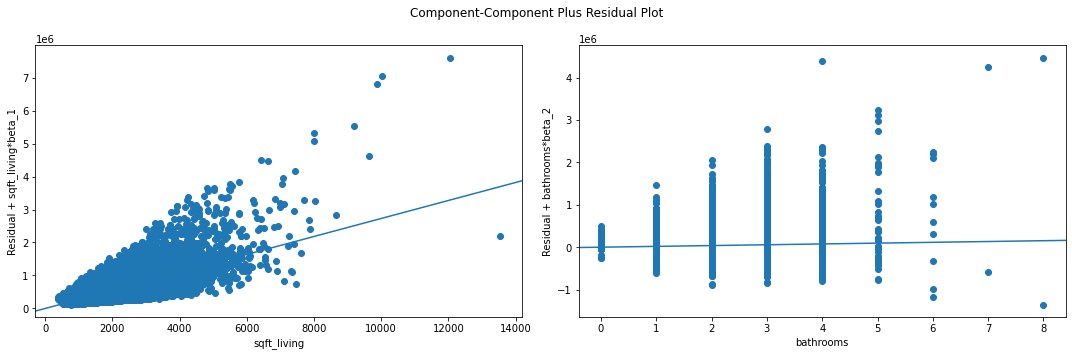

In [536]:
second_iteration.plot_ccpr()

### III. Third iteration

Given the small improvement shown in the last iteration, we switch gears on this iteration and add all other independent variables and then check the performance. If the performance does not improve significantly or we see some redundancy, we choose a variable to drop and check the performance again. If the performance is positively impactly, we go to the next step.

In [576]:
# evaluate the correlations
highest_corr(house_data_df, 'price', ['sqft_living', 'bathrooms', 'id'])

bedrooms    0.309057
sqft_lot    0.087430
floors      0.258797
yr_built    0.053433
Name: price, dtype: float64 

highest correlation:  {'bedrooms': 0.30905739979220165}


The number of floors should be discrete values so we floor the values to discrete values, before adding them to our model for analysis.

In [567]:
house_data_df['floors'].unique()

array([2. , 1. , 1.5, 3. , 2.5, 3.5])

In [578]:
house_data_df['floors'] = house_data_df['floors'].map(int)

In [579]:
X_all = house_data_df[['sqft_living', 'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'yr_built']]

third_iteration = RegressionAnalysis(house_data_df, y, X_all)

print(third_iteration.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4064.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:28:25   Log-Likelihood:            -2.6508e+05
No. Observations:               19164   AIC:                         5.302e+05
Df Residuals:                   19157   BIC:                         5.302e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.849e+06    1.5e+05     45.555      

### Interpretation:

### Third Iteration Regression Results

Looking at the summary above, we can see that the regression line we found was

$$ \hat{price} = 68,490 + 307.6017sqft\_living + 66,680bathrooms - 69,080bedrooms + 56,470floors - 0.3250sqft\_lot - 3517.4275yr\_built$$

* The model **is statistically significant** overall, with an **F-statistic p-value** well below 0.05
* The model exhibits an **R-squared value of 56%** of the variance in price.
    - indicating that approximately **56% of the variance in house prices is explained by the model in this iteration and its  predictor variables**
    - An overall improvement of 6.3% from the last model.
* The model coefficients are statistically significant, with t-statistic p-values well below 0.05
* For each increase of 1 square foot of living area, we see an associated increase in price of about $\$307.6017$
    - this here is an decrease of $-34.84$ from the last model, which means that number of bathrooms was meaningfully confounding in the relationship of the rest of the variables.
* For each increase of 1 bedroom, we see an associated decrease in price of about $\$-66,680$
* For each increase of 1 floor, we see an associated increase in price of about $\$56,470$
* For each increase of 1 Square footage of the lot, we see an associated decrease in price of about $\$0.3250$
* For each increase of 1 year, we see an associated decrease in price of about $\$-3517.4275$

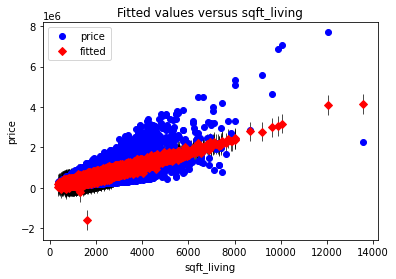

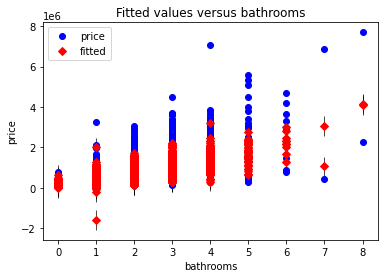

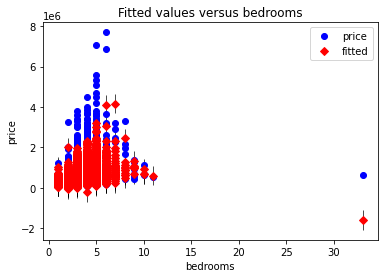

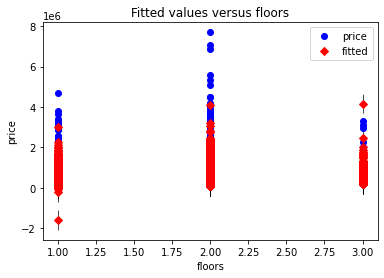

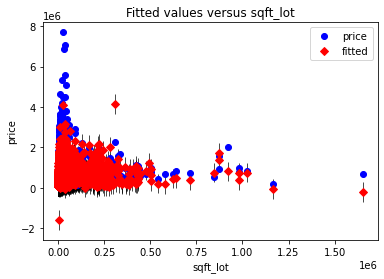

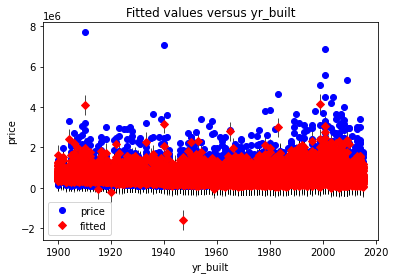

In [540]:
for var in X_all.columns:
    third_iteration.plot_fit(var)

 ### Model with Many Features Visualization
 
 We use a partial regression plot to display the contribution of each feature in the performance.
 
 #### Partial regression plot

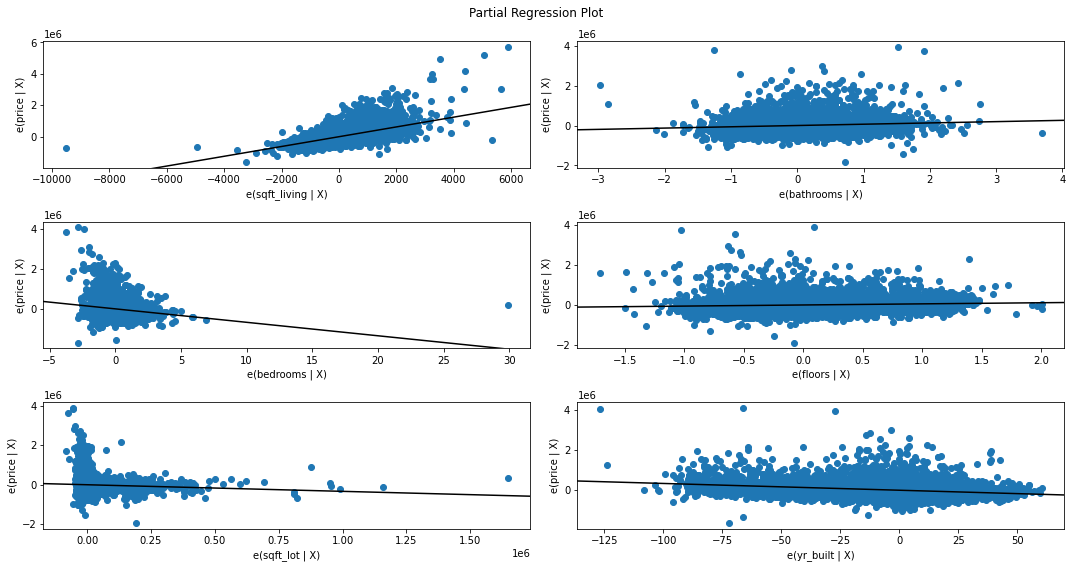

In [541]:
third_iteration.plot_partial_reg()

From the above partial regression plots we see that for some variables like `floors` and `sqft_lot` have slopes of near zero, meaning they do not contribute that much to the model.

But we retain them because they keep the performance high while still having a low p-value, way below our $\alpha$ of 0.05.

## Add a categorical variable


We add atleast one categorical value from our dataset in the model. There are 4 categorical variables in our dataset, namely:
- `waterfront`
- `view`
- `condition`
- `grade`

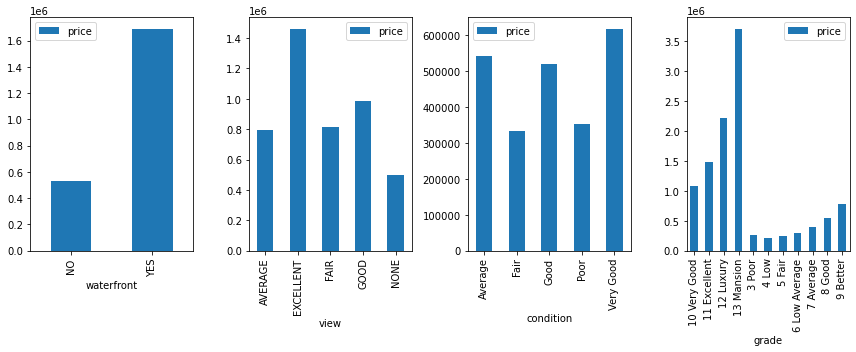

In [587]:
# Lets see the bar graphs of the categorical features

categorical_features = house_data_df.select_dtypes("object").columns
fig, axes = plt.subplots(ncols=len(categorical_features), figsize=(12,5))

for index, feature in enumerate(categorical_features):
    house_data_df.groupby(feature).mean().plot.bar(
        y="price", ax=axes[index])
plt.tight_layout()

We choose a categorical predictor that will be interpretable in our model below. We go with `view`, as this categorizes the condition of the house from **NONE** to **EXCELLENT**. 

Since typically for categorical features the data type is a `string`, we have to encode it numerically to allow regression modelling. 

So we create dummy variables (0 and 1) representing True or False  (**One-Hot Encoding**):

In [595]:
X_all = house_data_df[['sqft_living', 'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'yr_built', 'view']]

X_with_categ = pd.get_dummies(X_all, columns=["view"], dtype=int)

X_with_categ.head()

,sqft_living,bathrooms,bedrooms,floors,sqft_lot,yr_built,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
1,2570,2.25,3,2,7242,1951,0,0,0,0,1
2,770,1.00,2,1,10000,1933,0,0,0,0,1
3,1960,3.00,4,1,5000,1965,0,0,0,0,1
4,1680,2.00,3,1,8080,1987,0,0,0,0,1
5,5420,4.50,4,1,101930,2001,0,0,0,0,1


To avoid the **Dummy variable Trap** brought by when you can perfectly predict what one variable will be using some combination of the other variables, also known as **Multicollinearity**, we have to drop one of the dummy variables to break the collinearity.

The dummy variable to drop is the `view_NONE`, since it is the lowest category of the conditions.

This becomes our reference variable.

In [596]:
# drop the dummy variable condition_Poor
X_with_categ = X_with_categ.drop(columns='view_NONE')

X_with_categ.head()

,sqft_living,bathrooms,bedrooms,floors,sqft_lot,yr_built,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD
1,2570,2.25,3,2,7242,1951,0,0,0,0
2,770,1.00,2,1,10000,1933,0,0,0,0
3,1960,3.00,4,1,5000,1965,0,0,0,0
4,1680,2.00,3,1,8080,1987,0,0,0,0
5,5420,4.50,4,1,101930,2001,0,0,0,0


Now we check the impact of the model with the categorical variable:


In [597]:
# Create new model with categorical variable (condition)
model_with_categ = RegressionAnalysis(house_data_df, y, X_with_categ)

print(model_with_categ.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2800.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:25:31   Log-Likelihood:            -2.6431e+05
No. Observations:               19164   AIC:                         5.286e+05
Df Residuals:                   19153   BIC:                         5.287e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.132e+06   1.46e+05     41.

### Interpretation:

### Final Iteration Regression Results

Looking at the summary above, we can see that the regression line we found was

* The model **is statistically significant** overall, with an **F-statistic p-value** well below 0.05
* The model exhibits an **R-squared value of 59.4%** of the variance in price.
    - indicating that approximately **59.4% of the variance in house prices is explained by the model in this iteration and its  predictor variables**
    - An overall improvement of +3.4% from the last model.
* The model coefficients are statistically significant, with t-statistic p-values well below 0.05

* For each increase of 1 square foot of living area, we see an associated increase in price of about $\$280.9070 $
* For each increase of 1 bathroom, we see an associated increase in price of about $\$+60,670$
* For each increase of 1 bedroom, we see an associated decrease in price of about $\$-58,560$
* For each increase of 1 floor, we see an associated increase in price of about $\$+59,370$
* For each increase of 1 Square footage of the lot, we see an associated decrease in price of about $\$-0.3151$
* For each increase of 1 year, we see an associated decrease in price of about $\$-3147.8267$


* The intercept (const) implies that when all other variables are 0, and `view` is `NONE`, the price is  -$\$61,320$
#### Interpretation of categorical variables:
- Since our **`view_NONE`**is our reference category, we interpret the model summary in reference to it:\
i.e
    - A shift from a house with **no view** to one with a **FAIR view** impacts the price positively by +$\$125,400$   
    - A shift from a house with **no view** to one with a **GOOD view** impacts the price positively by +$\$161,800$
    - A shift from a house with **no view** to one with a **AVERAGE view** impacts the price positively by +$\$83,410$
    - A shift from a house with **no view** to one with a **EXCELLENT view** impacts the price positively by +$\$532,700$
    
A take-away from this is that house with an **AVERAGE** quality of view might be under-valued since our understanding seems to indicate that it should be better than one with **GOOD** view (+$\$161,800$). More investigation of other features
is needed to understand whether this can be explained by other variables, or if "GOOD" appears to be undervalued.